In [1]:
# allows showing the tensorboard widget
%load_ext tensorboard
# reload imports on rerun
%load_ext autoreload

# set to 1 for cuda debugging
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# show the tensorboard widget
%tensorboard --logdir lightning_logs

Launching TensorBoard...

In [2]:
# enable import reloads
%autoreload 2

import pytorch_lightning as lightning

import torch
from torch.utils.data import random_split
from torchvision.datasets.utils import download_and_extract_archive

import numpy as np
import matplotlib.pyplot as plt

import pathlib
from data import MeshDataset, SingleTensorDataset
from models import PointCloudsModule

import utils

In [3]:
plt.rc("figure", dpi=250)
plt.rc("legend", fontsize=6)

plots_path = pathlib.Path("plots")
samples_path = pathlib.Path("samples")

plots_path.mkdir(parents=True, exist_ok=True)
samples_path.mkdir(parents=True, exist_ok=True)

In [4]:
torch.autograd.set_grad_enabled(False)

In [5]:
url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
filename = pathlib.Path("ModelNet10.zip")
data_root = pathlib.Path("data")

In [6]:
# download_and_extract_archive(url=url, download_root=str(data_root), extract_root=str(data_root), filename=str(filename))

In [7]:
samples_per_mesh = 128

In [8]:
train_data = MeshDataset(root=data_root / "processed", split="train", shapes=["chair"], samples=samples_per_mesh)
n_train = int(0.8 * len(train_data))
n_val = len(train_data) - n_train

train_data, val_data = random_split(train_data, [n_train, n_val])

test_data = MeshDataset(root=data_root / "processed", split="test", shapes=["chair"], samples=samples_per_mesh)

len(train_data), len(val_data), len(test_data)

(711, 178, 100)

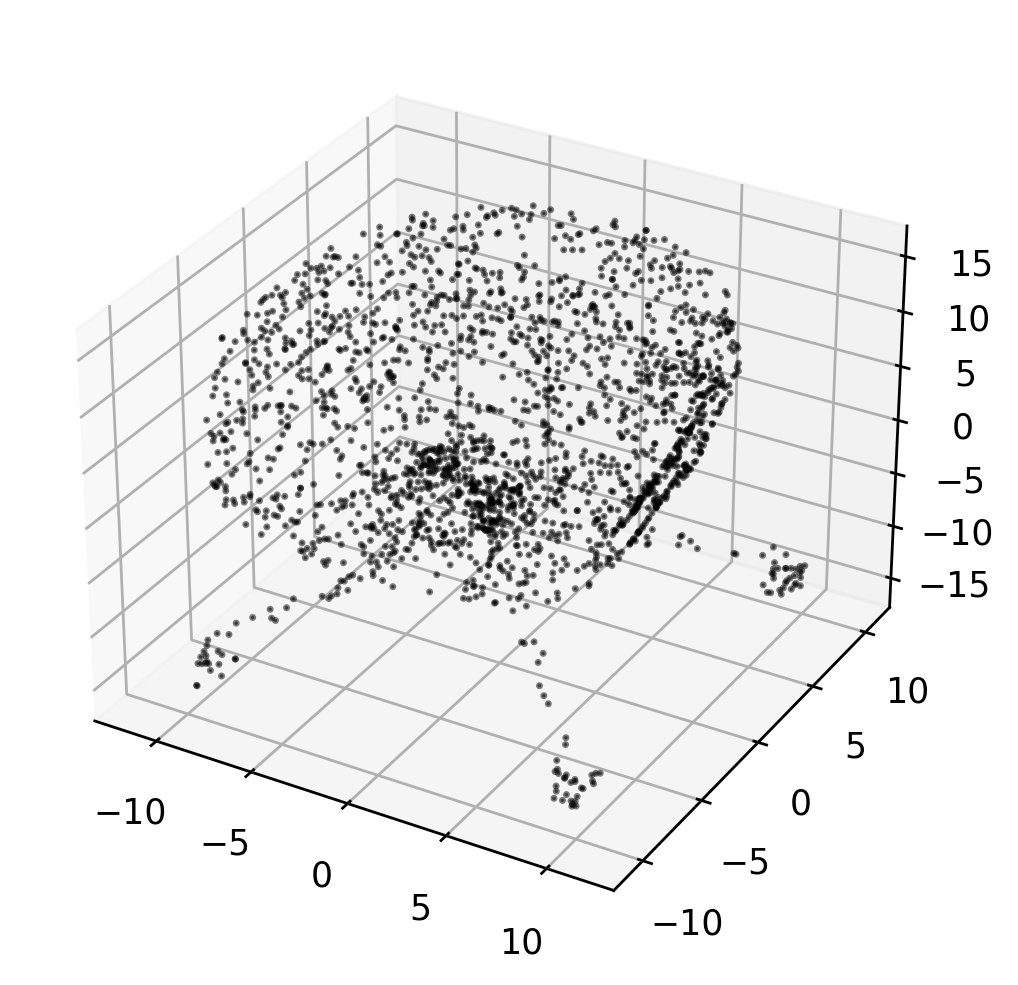

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
points = train_data[0]
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5)
# ax.set_axis_off()
plt.savefig(plots_path / "train_sample.png")

In [53]:
inputs = 3
conditions = 128

encoder_hparams = dict(
    inputs=inputs,
    points=samples_per_mesh,
    conditions=conditions,
    kind="deterministic",
    dropout=0.1,
    batchnorm=False,
    widths=[[8, 16, 32], [512, 256, 128]],
    activation="selu",
    # technically, the information bottleneck lies in the pooling (2048 -> 1), so it would be better to use approximately correct pooling (2048 -> N) where N >> 1
    # can use pre-trained stuff like torchsort or train with permutation invariance loss 
    # (or maybe just leave this part out completely and hope the network converges to permutation invariance anyway because it sees so many permutations in training)
    pooling="multimax",
    pools=32,
    Lambda=0.5,
)

rectifier_hparams = dict(
    inputs=inputs,
    conditions=conditions,
    dropout=0.1,
    batchnorm=False,  # FIXME
    widths=[128, 256, 256, 128],
    activation="selu",
    integrator="rk45",
)

hparams = dict(
    accelerator="gpu",
    devices=1,
    max_epochs=50,
    optimizer="adam",
    learning_rate=1e-3,
    weight_decay=1e-5,
    batch_size=9,
    accumulate_batches=None,
    gradient_clip=1.0,
    encoder_hparams=encoder_hparams,
    rectifier_hparams=rectifier_hparams,
    mmd_scales="all",
    mmd_samples=None,
    time_samples=8,
    beta=0.6,
)


In [54]:
model = PointCloudsModule(train_data, val_data, test_data, **hparams)
print(model)

x.shape=torch.Size([32, 3, 2048])
z.shape=torch.Size([32, 1024])
x.shape=torch.Size([10, 3, 2048])
x.shape=torch.Size([10, 3, 2048])
PointCloudsModule(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): GlobalMultimaxPool1d()
      (3): Conv1d(8, 32, kernel_size=(1,), stride=(1,))
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (post_encode): Sequential(
      (Input Layer): Linear(in_features=1024, out_features=512, bias=True)
      (Input Activation): SELU()
      (Dropout 1): Dropout1d(p=0.1, inplace=False)
      (Hidden Layer 1): Linear(in_features=512, out_features=256, bias=True)
      (Hidden Activation 1): SELU()
      (Dropout 2): Dropout1d(p=0.1, inplace=False)
      (Hidden Layer 2): Linear(in_features=256, out_features=128, bias=True)
      (Hidden Activation 2): SELU()
      (Output Layer): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (rectifier): Rectifier(
    (netw

In [52]:
trainer = model.configure_trainer()

with torch.autograd.enable_grad():
    model.train()
    trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | Encoder   | 705 K 
1 | rectifier | Rectifier | 149 K 
----------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

x.shape=torch.Size([1, 3, 2048])


RuntimeError: no valid convolution algorithms available in CuDNN

In [ ]:
best_model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
model = best_model

model.eval()

In [ ]:
model.hparams

In [ ]:
samples = model.sample(n_shapes=9, n_points=2048, steps=100)
torch.save(samples, samples_path / "random_samples.pt")

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "random_samples.png")

In [ ]:
%matplotlib widget
sample = model.sample(n_shapes=1, n_points=4096, steps=100).squeeze()
torch.save(sample, samples_path / "sample.pt")

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=1, color="black", alpha=0.5, lw=0)
plt.show()

In [ ]:
# sample multiple conditions with same latent representation, then interpolate (should deform shape, keeping points roughly same)
# or sample multiple latent variables with same condition, then interpolate (should move points along shape)

In [ ]:
samples = model.sample_shapes(n_shapes=9, n_points=2048, steps=100)
torch.save(samples, samples_path / "shapes.pt")

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "shapes.png")

In [ ]:
samples = model.sample_variations(n_shapes=9, n_points=2048, steps=100)
torch.save(samples, samples_path / "variations.pt")

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "variations.png")

In [ ]:
plt.ioff()
rows = 100
cols = 6
width = cols
height = rows
fig = plt.figure(figsize=(width, height))
for i, batch in enumerate(train_data):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(batch[:, 0], batch[:, 1], batch[:, 2], color="black", alpha=0.5, s=1, lw=0)
    ax.set_axis_off()
    
    if i == rows * cols - 1:
        break

# set the spacing between subplots
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
plt.show()

In [ ]:
model.hparams